<a href="https://colab.research.google.com/github/RicardxJMG/deep-learning-diplomado/blob/main/Tareas/%22Tarea%209%20-%20Tipos%20de%20Cobertura%20Superficial%20%5Bclasificaci%C3%B3n%20multiclase%5D.ipynb%22" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación - Tipos de Cobertura Superficial

**Cita**: Blackard, J. (1998). Covertype [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C50K5N.

**Problema**: Clasificación multiclase de tipos de vegetación usando datos cartográficos.

**Objetivo**: Predecir el tipo de cobertura forestal predominante (1-7 clases) en áreas del Parque Nacional Roosevelt utilizando variables topográficas, de distancia y ambientales. Es un problema de gran escala con datos desbalanceados.


### Descripción de la tabla

|Columna|Descripción|Tipo de Dato|Rango/Valores Típicos|
|---|---|---|---|
|**Cover_Type**|**Variable target** - Tipo de cobertura forestal|Entero (1-7)|7 clases de vegetación|
|Elevation|Elevación sobre el nivel del mar|Numérico|1860-3850 metros|
|Aspect|Orientación de la pendiente (azimut)|Numérico|0-360 grados|
|Slope|Pendiente del terreno|Numérico|0-66 grados|
|Horizontal_Distance_To_Hydrology|Distancia horizontal al cuerpo de agua más cercano|Numérico|0-1343 metros|
|Vertical_Distance_To_Hydrology|Distancia vertical al cuerpo de agua más cercano|Numérico|-146-554 metros|
|Horizontal_Distance_To_Roadways|Distancia horizontal al camino más cercano|Numérico|0-7117 metros|
|Hillshade_9am|Índice de sombreado a las 9 AM|Numérico|0-255 (índice)|
|Hillshade_Noon|Índice de sombreado al mediodía|Numérico|0-255 (índice)|
|Hillshade_3pm|Índice de sombreado a las 3 PM|Numérico|0-255 (índice)|
|Horizontal_Distance_To_Fire_Points|Distancia horizontal al punto de incendio más cercano|Numérico|0-7173 metros|
|Wilderness_Area|Área silvestre (4 áreas posibles)|Entero (1-4)|Código categórico|
|Soil_Type|Tipo de suelo (40 tipos posibles)|Entero (1-40)|Código categórico|

#### Clases de la tabla


|Código|Tipo de Cobertura Forestal|
|---|---|
|1|Picea-abeto (Spruce/Fir)|
|2|Pino de hoja corta (Lodgepole Pine)|
|3|Pino de hoja larga (Ponderosa Pine)|
|4|Algodoncillo (Cottonwood/Willow)|
|5|Álamo temblón (Aspen)|
|6|Abeto Douglas (Douglas-fir)|
|7|Madera de Krummholz (Krummholz)|


## 1. Importando datos y procesando datos


Para poder correr correctamente este notebook se deben de cargar los scripts de la carpeta [src](https://github.com/RicardxJMG/deep-learning-diplomado/tree/main/tareas/src) de este repositorio.

In [ ]:
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from src.data_processor import DataProcessor, process_new_data_with_artifacts
from src.save_to_zip import save_processed_data_to_zip
from src.neural_net_designer import  MulticlassClassificationDesigner
from src.load_from_zip import load_processed_data_from_zip


SEED = 321
np.random.seed(SEED)

warnings.filterwarnings('ignore')
datapath = Path('data')

processed_path = datapath / 'processed'
processed_path.mkdir(parents = True, exist_ok = True)

In [ ]:
df = pd.read_csv(datapath / 'covtype.csv')
df.sample(n=3, random_state=SEED)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Wilderness_Area,Soil_Type
326546,2517,144,18,42,13,1376,242,234,114,1269,3,3,4
103124,2913,191,10,60,-2,4901,220,248,161,4502,2,1,30
429934,2921,307,18,541,275,1370,167,226,198,1825,2,3,33


In [ ]:
print('El conjunto de datos tiene una dimensión de ', df.shape[0], 'filas y ', df.shape[1], ' columnas.')

El conjunto de datos tiene una dimensión de  580012 filas y  13  columnas.


In [ ]:
targert = 'Cover_Type'
cat_cols = ['Wilderness_Area', 'Soil_Type']
num_cols = df.drop(columns = [targert] + cat_cols, axis = 1).columns.to_list()


config = {
    'target': targert,
    'cols_cat': cat_cols,
    'cols_num': num_cols,
    'cols_onehot': cat_cols,
    'stratify': True
}

processor = DataProcessor(**config)
resultados = processor.process(datapath / 'covtype.csv')
artifacts = resultados['artifacts']


Resumen del preprocesamiento:
X_train_final: (371207, 54)
X_val_final  : (92802, 54)
X_test_final : (116003, 54)
Total de características: 54
  - Numéricas: 10
  - Categóricas procesadas: 44


In [ ]:
#@title ### 1.1 Guardando datos procesados

save_processed_data_to_zip(zip_path = processed_path / 'covtype_procesado.zip',
                             processed_data = resultados,
                             printpath = True)

Datos procesados guardados en data/processed/covtype_procesado.zip


## 2. Construcción y entrenamiento de la red


In [ ]:
#@title ### 1. Cargando datos procesado.

print('-'*60)

train_loaded, val_loaded, test_loaded, _, metadata = load_processed_data_from_zip(processed_path / 'covtype_procesado.zip', prinpath = True)

print('-'*60)

X_train = train_loaded.drop(columns = ["target"])
y_train = train_loaded["target"]

X_val = val_loaded.drop(columns = ["target"])
y_val = val_loaded["target"]

X_test = test_loaded.drop(columns= ["target"])
y_test = test_loaded["target"]

print('> El target es: ', metadata['target'])
print("> X_train.shape = ", X_train.shape)
print("> X_val.shape = ", X_val.shape)
print("> X_test.shape = ", X_test.shape)




------------------------------------------------------------
Datos extraidos desde data/processed/covtype_procesado.zip correctamente
------------------------------------------------------------
> El target es:  Cover_Type
> X_train.shape =  (371207, 54)
> X_val.shape =  (92802, 54)
> X_test.shape =  (116003, 54)


In [ ]:
#@title 2.2 Mapeo Automático de Etiquetas

y_train_raw = y_train.astype(int)['target']
y_val_raw = y_val.astype(int)['target']
y_test_raw = y_test.astype(int)['target']

d  = X_train.shape[0]
n0 = X_train.shape[1]

classes_original = np.sort(y_train_raw.unique())
K = int(len(classes_original))

class_to_index = {int(c): int(i) for i, c in enumerate(classes_original)}
index_to_class = {int(i): int(c) for i, c in enumerate(classes_original)}

def map_labels(y_series: pd.Series, mapping: dict) -> np.ndarray:
    y_mapped = y_series.map(mapping)
    if y_mapped.isna().any():
        unseen = sorted(set(y_series.unique()) - set(mapping.keys()))
        raise ValueError(
            f"Clases en val/test no vistas en train: {unseen}. "
            f"Revisa el split/stratify o la construcción de datasets."
        )
    return y_mapped.astype(int).values

y_train = map_labels(y_train_raw, class_to_index)
y_val   = map_labels(y_val_raw, class_to_index)
y_test  = map_labels(y_test_raw, class_to_index)

print("d =", d)
print("n0 =", n0)
print("K =", K)
print("classes_original (train) =", classes_original.tolist())
print("class_to_index =", class_to_index)


d = 371207
n0 = 54
K = 7
classes_original (train) = [1, 2, 3, 4, 5, 6, 7]
class_to_index = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}


In [ ]:
#@title ### 2.3 Detección de Desbalanceo

counts = pd.Series(y_train).value_counts().sort_index()
counts = counts.reindex(range(K), fill_value=0)

min_c = int(counts.min())
max_c = int(counts.max())
imbalance_ratio = (max_c / min_c) if min_c > 0 else float("inf")

IMBALANCE_THRESHOLD = 1.5
usa_class_weight = bool(imbalance_ratio >= IMBALANCE_THRESHOLD)

class_weight = None
if usa_class_weight:
    total = float(len(y_train))
    class_weight = {int(i): float(total / (K * counts.loc[i])) for i in range(K)}

print("\n=== Desbalanceo (train, índices internos) ===")
print("counts (idx->n):\n", counts.to_string())
print("imbalance_ratio (max/min):", float(imbalance_ratio))
print("IMBALANCE_THRESHOLD:", float(IMBALANCE_THRESHOLD))
print("¿Se usará class_weight?:", usa_class_weight)
if usa_class_weight:
    print("class_weight (idx->w):", class_weight)





=== Desbalanceo (train, índices internos) ===
counts (idx->n):
 0    135350
1    181000
2     22838
3      1756
4      6066
5     11095
6     13102
imbalance_ratio (max/min): 103.0751708428246
IMBALANCE_THRESHOLD: 1.5
¿Se usará class_weight?: True
class_weight (idx->w): {0: 0.39179587313314684, 1: 0.29298105761641674, 2: 2.321988415297812, 3: 30.199072567523594, 4: 8.742098817766474, 5: 4.779591836734694, 6: 4.047440957759993}


In [ ]:
# ============================================================
#@title ### 3. Configuración de evaluación (simetría vs clases críticas)
# ============================================================
#
# True  -> clases "simétricas" -> optimizamos Accuracy
# False -> robustez ante desbalanceo -> optimizamos Macro-F1
#
# NOTA: En cualquier caso reportamos Accuracy, Macro-F1 y Weighted-F1.
# ============================================================

CLASES_SIMETRICAS = False

### 2.4 Construcción de la red

In [ ]:
multi_classification = MulticlassClassificationDesigner()
diseno = multi_classification.desing(d,n0,K)
print(diseno)

DisenoRedMulticlase(capas=[108, 54, 27, 13], P=13773, rho=0.0037103287384127994, l2=3e-05, dropouts=[0.05, 0.05, 0.05, 0.05], patience=10, min_delta=0.0001, max_epochs=100)


In [ ]:
capas     = diseno.capas
l2_value  = diseno.l2
dropouts  = diseno.dropouts
patience  = diseno.patience
min_delta = diseno.min_delta
max_epochs= diseno.max_epochs

def build_multiclass_mlp(n0: int, K: int, capas: list, l2_value: float, dropouts: list) -> keras.Model:
    assert len(capas) == len(dropouts), "capas y dropouts deben tener la misma longitud"

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(n0,)))

    for units, dr in zip(capas, dropouts):
        model.add(
            keras.layers.Dense(
                units,
                activation="relu",
                kernel_regularizer=keras.regularizers.l2(l2_value)
            )
        )
        model.add(keras.layers.Dropout(dr))

    model.add(keras.layers.Dense(K, activation="softmax"))


    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )

    return model

model = build_multiclass_mlp(n0=n0, K=K, capas=capas, l2_value=l2_value, dropouts=dropouts)

In [ ]:
# ============================================================
#@title ### 2.5 Entrenar + validar (EarlyStopping) + class_weight si aplica
# ============================================================

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,
        verbose=1
    )
]

BATCH_SIZE = 64

fit_kwargs = {}
if usa_class_weight and (class_weight is not None):
    fit_kwargs["class_weight"] = class_weight  # SOLO si hay desbalanceo

history = model.fit(
    X_train.astype(np.float32),
    y_train,
    validation_data=(X_val.astype(np.float32), y_val),
    epochs=max_epochs,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=callbacks,
    **fit_kwargs
)

Epoch 1/100
5801/5801 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.5473 - loss: 0.8893 - val_accuracy: 0.6342 - val_loss: 0.8384
Epoch 2/100
5801/5801 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6406 - loss: 0.6002 - val_accuracy: 0.6834 - val_loss: 0.7241
Epoch 3/100
5801/5801 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6715 - loss: 0.5499 - val_accuracy: 0.6958 - val_loss: 0.7223
Epoch 4/100
5801/5801 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6924 - loss: 0.5023 - val_accuracy: 0.7186 - val_loss: 0.6801
Epoch 5/100
5801/5801 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7065 - loss: 0.4778 - val_accuracy: 0.7252 - val_loss: 0.6812
Epoch 6/100
5801/5801 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7180 - loss: 0.4664 - val_accuracy: 0.7471 - val_loss: 0.6218
Epoch 7/100
5801/5801 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.7236 - loss: 0.4523 - val_accuracy: 0.7512 - val_loss: 0.6196
Epoch 8/100
5801/5801 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.7305 -

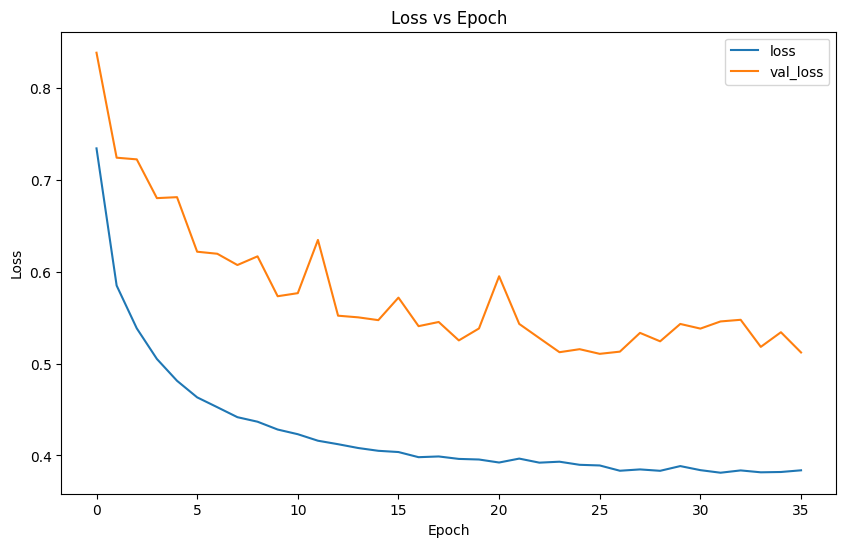

In [ ]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

figure = plt.figure(figsize=(10, 6))
ax = plt.gca()
history_df.plot(y=["loss", "val_loss"], ax=ax)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epoch")

plt.show()

## 3. Evaluación + métricas robustas


In [ ]:
#@title ### 3.1 Configuraciones
import os
import json
import zipfile

def confusion_matrix_multiclass(y_true: np.ndarray, y_pred: np.ndarray, K: int) -> np.ndarray:
    cm = np.zeros((K, K), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm

def accuracy_from_cm(cm: np.ndarray) -> float:
    total = cm.sum()
    return float(np.trace(cm) / total) if total else 0.0

def f1_per_class_from_cm(cm: np.ndarray):
    K = cm.shape[0]
    f1s = np.zeros(K, dtype=float)
    support = cm.sum(axis=1).astype(float)
    for k in range(K):
        TP = cm[k, k]
        FP = cm[:, k].sum() - TP
        FN = cm[k, :].sum() - TP
        denom = 2*TP + FP + FN
        f1s[k] = (2*TP / denom) if denom else 0.0
    return f1s, support

def f1_macro_from_cm(cm: np.ndarray) -> float:
    f1s, _ = f1_per_class_from_cm(cm)
    return float(np.mean(f1s)) if len(f1s) else 0.0

def f1_weighted_from_cm(cm: np.ndarray) -> float:
    f1s, support = f1_per_class_from_cm(cm)
    total = float(support.sum())
    if total <= 0:
        return 0.0
    w = support / total
    return float((w * f1s).sum())

def print_confusion_matrix_multiclass(cm: np.ndarray, *, title="Matriz de confusión"):
    print(f"\n{title}: (filas=True, columnas=Pred) [índices internos 0..K-1]")
    K = cm.shape[0]
    header = "True\Pred | " + " ".join([f"{j:6d}" for j in range(K)])
    print(header)
    print("-" * len(header))
    for i in range(K):
        row = " ".join([f"{cm[i,j]:6d}" for j in range(K)])
        print(f"{i:9d} | {row}")


In [ ]:
#@title ### 3.2 Validación

p_val = model.predict(X_val.astype(np.float32), verbose=0)
yhat_val = np.argmax(p_val, axis=1).astype(int)

cm_val = confusion_matrix_multiclass(y_val, yhat_val, K)
acc_val = accuracy_from_cm(cm_val)
f1m_val = f1_macro_from_cm(cm_val)
f1w_val = f1_weighted_from_cm(cm_val)

metric_principal = "Accuracy" if CLASES_SIMETRICAS else "Macro-F1"
score_val_principal = acc_val if CLASES_SIMETRICAS else f1m_val

print("\n=== Configuración de decisión (multiclase) ===")
print("Métrica principal:", metric_principal)
print("¿Clases 'simétricas'?:", bool(CLASES_SIMETRICAS))
print("Regla de decisión:", "argmax(softmax)")
print("Score en VALIDACIÓN (métrica principal):", float(score_val_principal))

print("¿Se usó class_weight?:", bool(usa_class_weight))
if usa_class_weight:
    print("IMBALANCE_THRESHOLD:", float(IMBALANCE_THRESHOLD))
    print("imbalance_ratio (train max/min):", float(imbalance_ratio))

print_confusion_matrix_multiclass(cm_val, title="Matriz de confusión (VALIDACIÓN)")

print("\nMétricas en validación:")
print("-----------------------------------")
print(f"{'Métrica':<15} | {'Valor':>10}")
print("-----------------------------------")
print(f"{'Accuracy':<15} | {acc_val:10.4f}")
print(f"{'Macro-F1':<15} | {f1m_val:10.4f}")
print(f"{'Weighted-F1':<15} | {f1w_val:10.4f}")
print("-----------------------------------")



=== Configuración de decisión (multiclase) ===
Métrica principal: Macro-F1
¿Clases 'simétricas'?: False
Regla de decisión: argmax(softmax)
Score en VALIDACIÓN (métrica principal): 0.7438465422571302
¿Se usó class_weight?: True
IMBALANCE_THRESHOLD: 1.5
imbalance_ratio (train max/min): 103.0751708428246

Matriz de confusión (VALIDACIÓN): (filas=True, columnas=Pred) [índices internos 0..K-1]
True\Pred |      0      1      2      3      4      5      6
------------------------------------------------------------
        0 |  27861   4413     11      0    286     24   1243
        1 |   6467  34819    629     12   2028   1071    224
        2 |      0     16   4557    268     52    817      0
        3 |      0      0      8    427      0      4      0
        4 |      5     61      6      0   1429     15      0
        5 |      1      5    163     67      4   2534      0
        6 |     90      2      0      0      1      0   3182

Métricas en validación:
---------------------------------

In [ ]:
#@title ### 3.3 Testing

p_test = model.predict(X_test.astype(np.float32), verbose=0)
yhat_test = np.argmax(p_test, axis=1).astype(int)

cm_test = confusion_matrix_multiclass(y_test, yhat_test, K)
acc_test = accuracy_from_cm(cm_test)
f1m_test = f1_macro_from_cm(cm_test)
f1w_test = f1_weighted_from_cm(cm_test)

print_confusion_matrix_multiclass(cm_test, title="Matriz de confusión (TEST)")

print("\nMétricas en test:")
print("-----------------------------------")
print(f"{'Métrica':<15} | {'Valor':>10}")
print("-----------------------------------")
print(f"{'Accuracy':<15} | {acc_test:10.4f}")
print(f"{'Macro-F1':<15} | {f1m_test:10.4f}")
print(f"{'Weighted-F1':<15} | {f1w_test:10.4f}")
print("-----------------------------------")



Matriz de confusión (TEST): (filas=True, columnas=Pred) [índices internos 0..K-1]
True\Pred |      0      1      2      3      4      5      6
------------------------------------------------------------
        0 |  34831   5444      6      0    347     45   1624
        1 |   8054  43401    819      7   2639   1390    253
        2 |      0     18   5730    347     64    978      0
        3 |      0      0      6    533      0     10      0
        4 |      3     63     15      0   1795     19      0
        5 |      0     10    180    102      5   3170      0
        6 |     82      2      0      0      0      0   4011

Métricas en test:
-----------------------------------
Métrica         |      Valor
-----------------------------------
Accuracy        |     0.8058
Macro-F1        |     0.7417
Weighted-F1     |     0.8110
-----------------------------------


In [ ]:
#@title ### 3.4 Guardando los resultados

OUT_DIR = "salida_multiclase"
ZIP_NAME = "resultados.zip"
os.makedirs(OUT_DIR, exist_ok=True)

metadata = {
    "problem_type": "multiclass_classification",

    "n_samples_train": int(d),
    "n_features": int(n0),
    "n_classes": int(K),

    # --- mapeo crítico ---
    "classes_original_train": [int(c) for c in classes_original],
    "class_to_index": {str(int(k)): int(v) for k, v in class_to_index.items()},
    "index_to_class": {str(int(k)): int(v) for k, v in index_to_class.items()},

    "architecture": capas,
    "l2": float(l2_value),
    "dropouts": dropouts,
    "patience": int(patience),
    "min_delta": float(min_delta),
    "max_epochs": int(max_epochs),

    # --- decisión / prioridad ---
    "clases_simetricas": bool(CLASES_SIMETRICAS),
    "metrica_principal": metric_principal,
    "decision_rule": "argmax_softmax",

    # --- desbalanceo / pesos ---
    "imbalance_threshold": float(IMBALANCE_THRESHOLD),
    "imbalance_ratio_train_max_min": float(imbalance_ratio),
    "used_class_weight": bool(usa_class_weight),
    "class_counts_train_indexed": {str(int(k)): int(v) for k, v in counts.items()},
    "class_weight_indexed": None if not usa_class_weight else {str(int(k)): float(v) for k, v in class_weight.items()},

    # --- resultados ---
    "metrics_val": {
        "accuracy": float(acc_val),
        "macro_f1": float(f1m_val),
        "weighted_f1": float(f1w_val),
    },
    "metrics_test": {
        "accuracy": float(acc_test),
        "macro_f1": float(f1m_test),
        "weighted_f1": float(f1w_test),
    },

    "confusion_matrix_val_indexed": cm_val.tolist(),
    "confusion_matrix_test_indexed": cm_test.tolist(),
}

with open(os.path.join(OUT_DIR, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)

model_path = os.path.join(OUT_DIR, "modelo.keras")
model.save(model_path)

history_path = os.path.join(OUT_DIR, "historial_entrenamiento.csv")
pd.DataFrame(history.history).to_csv(history_path, index=False)

with zipfile.ZipFile(ZIP_NAME, "w", zipfile.ZIP_DEFLATED) as zipf:
    for file in [model_path, history_path, os.path.join(OUT_DIR, "metadata.json")]:
        zipf.write(file, arcname=os.path.basename(file))

print(f"\n✔ ZIP generado correctamente: {ZIP_NAME}")



✔ ZIP generado correctamente: resultados.zip


## 4. Entrenado el modelo con datos nuevos

In [ ]:
covtype_nuevos = pd.read_csv(datapath / 'covtype_nuevos.csv')
target_nuevos_raw = pd.read_csv(datapath / 'covtype_nuevos_target.csv')

print(covtype_nuevos.shape)
print(target_nuevos_raw.shape)

(1000, 12)
(1000, 1)


In [ ]:
#@title ### 4.1 Procesando da tos nuevos

nuevos_procesados = process_new_data_with_artifacts(covtype_nuevos, artifacts)


Nuevos datos procesados: (1000, 54)


In [ ]:
target_nuevos = map_labels(target_nuevos_raw['Cover_Type'], class_to_index)

p_nuevos = model.predict(nuevos_procesados.astype(np.float32), verbose=0)
yhat_nuevos = np.argmax(p_nuevos, axis=1).astype(int)

cm_nuevos = confusion_matrix_multiclass(target_nuevos, yhat_nuevos, K)
acc_nuevos = accuracy_from_cm(cm_nuevos)
f1m_nuevos = f1_macro_from_cm(cm_nuevos)
f1w_nuevos = f1_weighted_from_cm(cm_nuevos)

print_confusion_matrix_multiclass(cm_nuevos, title="Matriz de confusión (nuevos)")

print("\nMétricas en nuevos:")
print("-----------------------------------")
print(f"{'Métrica':<15} | {'Valor':>10}")
print("-----------------------------------")
print(f"{'Accuracy':<15} | {acc_nuevos:10.4f}")
print(f"{'Macro-F1':<15} | {f1m_nuevos:10.4f}")
print(f"{'Weighted-F1':<15} | {f1w_nuevos:10.4f}")
print("-----------------------------------")



Matriz de confusión (nuevos): (filas=True, columnas=Pred) [índices internos 0..K-1]
True\Pred |      0      1      2      3      4      5      6
------------------------------------------------------------
        0 |    287     46      0      0      4      0     18
        1 |     75    372      4      0     25      9      3
        2 |      0      0     56      5      2      6      0
        3 |      0      0      0      3      0      0      0
        4 |      0      0      0      0     16      0      0
        5 |      0      0      2      1      0     28      0
        6 |      2      0      0      0      0      0     36

Métricas en nuevos:
-----------------------------------
Métrica         |      Valor
-----------------------------------
Accuracy        |     0.7980
Macro-F1        |     0.7139
Weighted-F1     |     0.8050
-----------------------------------


## Conclusiones del Análisis de Clasificación de Cobertura Superficial

A partir de los resultados obtenidos en este notebook, se pueden extraer las siguientes conclusiones:

### 1. Desbalance de Datos
*   **Detección**: Se identificó un significativo desbalance en las clases de la variable objetivo 'Cover_Type' en el conjunto de entrenamiento. La relación de desbalance (max/min) fue de aproximadamente **103.08**, superando el umbral de 1.5, lo que indica un fuerte desequilibrio entre la clase más frecuente y la menos frecuente.
*   **Manejo**: Para mitigar el impacto de este desbalance, se aplicó la técnica de `class_weight` durante el entrenamiento del modelo. Esto asignó pesos mayores a las clases minoritarias, buscando que el modelo prestara más atención a estas durante el aprendizaje y mejorara su capacidad de predecir clases con menos ejemplos.

### 2. Rendimiento del Modelo en el Conjunto de Datos (Validación y Test)
*   **Métrica Principal**: Dada la naturaleza desbalanceada del problema, se configuró `Macro-F1` como la métrica principal para evaluar el rendimiento, ya que proporciona una medida más robusta que la precisión (_Accuracy_) en estos escenarios, al ponderar por igual el F1-Score de cada clase.
*   **Resultados de Validación**:
    *   Accuracy: 0.8061
    *   Macro-F1: 0.7438
    *   Weighted-F1: 0.8111
*   **Resultados de Test**:
    *   Accuracy: 0.8058
    *   Macro-F1: 0.7417
    *   Weighted-F1: 0.8110
*   **Estabilidad**: Los resultados en los conjuntos de validación y test son muy similares, lo que sugiere que el modelo tiene un buen poder de generalización y no está sufriendo de un sobreajuste significativo. La métrica principal (Macro-F1) muestra un rendimiento consistente alrededor del 74%.

### 3. Predicciones con Datos Nuevos
*   **Rendimiento**:
    *   Accuracy: 0.7980
    *   Macro-F1: 0.7139
    *   Weighted-F1: 0.8050
*   **Consistencia**: El rendimiento del modelo en los datos nuevos sigue una tendencia similar a la observada en los conjuntos de validación y test. Si bien el Macro-F1 es ligeramente inferior (71.39% frente a ~74%), esto puede deberse a variaciones naturales en el nuevo subconjunto de datos o a diferencias sutiles en la distribución de las clases. Sin embargo, mantiene una buena capacidad predictiva general.

### Resumen General
El modelo de red neuronal profunda desarrollado demuestra ser eficaz en la clasificación de tipos de cobertura forestal, incluso frente a un considerable desbalance de clases en los datos de entrenamiento. La aplicación de `class_weight` fue fundamental para lograr un rendimiento razonable en las clases minoritarias, reflejado en un Macro-F1 superior al 70% tanto en los conjuntos de evaluación como en los datos nuevos. La consistencia de las métricas en los diferentes conjuntos de datos indica una buena generalización del modelo. Este análisis provee una base sólida para la predicción de la cobertura forestal, un problema de gran escala y relevancia ambiental.